In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler

In [3]:
input_size = 1 
num_steps = 1 
lstm_size = 128 
num_layers=1
keep_prob=0.8
batch_size = 64
learning_rate = 0.001
max_epoch = 100
test_train_split = 0.8

In [4]:
prices_dataset_train =  pd.read_csv('Google_Stock_Price_Train.csv', header=0)
prices_dataset_test =  pd.read_csv('Google_Stock_Price_Test.csv', header=0)

In [5]:
google_stock_prices_train = prices_dataset_train.Open.values.astype('float32')
google_stock_prices_test = prices_dataset_test.Open.values.astype('float32')
print("train shape: ",google_stock_prices_train.shape)
print("test shape: ",google_stock_prices_test.shape)

train shape:  (1258,)
test shape:  (20,)


In [6]:
## preprocessing of data, scale data into a scale of 0 to 1
scaler = MinMaxScaler(feature_range=(0, 1))
google_stock_prices_train = scaler.fit_transform(google_stock_prices_train)
google_stock_prices_test = scaler.fit_transform(google_stock_prices_test)
print(google_stock_prices_train.shape)
print(google_stock_prices_test.shape)

(1258,)
(20,)


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\sklearn\preprocessing\data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either usin

In [7]:
def create_dataset(seq, input_size, num_steps):
    # group according to input size
    seq = [np.array(seq[i * input_size: (i + 1) * input_size]) for i in range(len(seq) // input_size)]
    #print(seq.shape)
    
    # Split into groups of `num_steps`
    X = np.array([seq[i: i + num_steps] for i in range(len(seq) - num_steps)])
    y = np.array([seq[i + num_steps] for i in range(len(seq) - num_steps)])
    #print(X)
    #print("starting Y")
    #print(y)
    return X,y

In [8]:
train = google_stock_prices_train
test = google_stock_prices_test

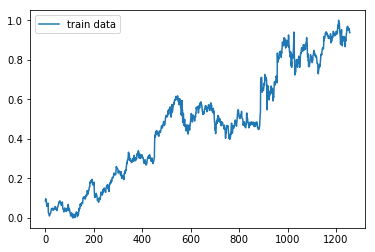

In [9]:
# train data
plt.plot(train, label = 'train data')
plt.legend(loc=0)

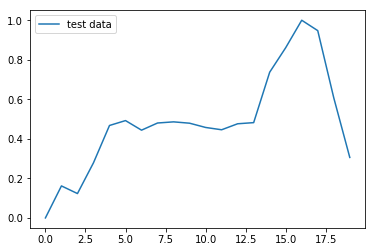

In [10]:
#test data
plt.plot(test, label ='test data')
plt.legend(loc=0)

In [11]:
## create data test and train
train_x,train_y = create_dataset(train,input_size, num_steps)
test_x,test_y = create_dataset(test,input_size, num_steps)
print(train_x.shape)

(1257, 1, 1)


In [12]:
tf.reset_default_graph()
ann_graph = tf.Graph()

In [13]:
with ann_graph.as_default():
    inputs = tf.placeholder(tf.float32, [None, num_steps, input_size])
    targets = tf.placeholder(tf.float32, [None, input_size])
    # reshape the inputs
    inputs_reshape = tf.reshape(inputs, [-1, num_steps * input_size])
        
    # declare weights and biases
    W1 = tf.get_variable(name='W1', shape=[num_steps * input_size, lstm_size], 
                          initializer = tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
    
    B1 = tf.get_variable(name='B1', shape=[lstm_size], 
                          initializer = tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
    
    H1 = tf.nn.bias_add(name='H1', value=tf.matmul(inputs_reshape, W1), bias=B1)
    
    H1 = tf.nn.relu(H1)
    
    W2 = tf.get_variable(name='W2', shape=[lstm_size, 1], 
                          initializer = tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
    
    B2 = tf.get_variable(name='B2', shape=[1], 
                          initializer = tf.contrib.layers.xavier_initializer(uniform=True, seed=None, dtype=tf.float32))
    
    logits = tf.nn.bias_add(name='logits', value=tf.matmul(H1, W2), bias=B2)
    
    ## define cost function and minimize it
    loss = tf.reduce_mean(tf.square(logits - targets))
    optimizer = tf.train.AdamOptimizer(learning_rate)
    minimize = optimizer.minimize(loss)

In [14]:
with tf.Session(graph=ann_graph) as sess:
    tf.global_variables_initializer().run()
    
    for epoch_step in range(max_epoch):
        avg_cost = 0.
        total_batch = int(len(train_x)/batch_size)
        
        for i in range(total_batch):
            batch_X = train_x[(i * batch_size) : ((i * batch_size) + batch_size)]
            batch_y = train_y[(i * batch_size) : ((i * batch_size) + batch_size)]
            train_loss, _ = sess.run([loss, minimize], feed_dict = {inputs: batch_X, targets: batch_y})
            avg_cost += train_loss / total_batch
            
        if (epoch_step) % 10 == 0:
            print("Epoch:", '%04d' % (epoch_step+1), "cost= ",(avg_cost))
    
    prd_value = sess.run(logits, feed_dict = {inputs: test_x})

Epoch: 0001 cost=  0.498202828985
Epoch: 0011 cost=  0.00259356645294
Epoch: 0021 cost=  0.000332922177653
Epoch: 0031 cost=  0.00028367439556
Epoch: 0041 cost=  0.000262227957903
Epoch: 0051 cost=  0.000252393049059
Epoch: 0061 cost=  0.000247189374166
Epoch: 0071 cost=  0.000244656534434
Epoch: 0081 cost=  0.000242837054094
Epoch: 0091 cost=  0.000242400963448


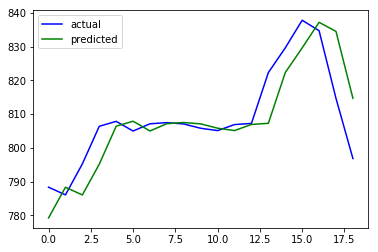

In [15]:
# unscale the data first
test_unscaled = scaler.inverse_transform(test_y)
prd_value_unscaled = scaler.inverse_transform(prd_value)

# plot the data points
plt.plot(test_unscaled[:],'b', label = 'actual')
plt.plot(prd_value_unscaled[:],'g', label = 'predicted')
plt.legend(loc=0)

In [16]:
tf.reset_default_graph()
lstm_graph = tf.Graph()

In [17]:
with lstm_graph.as_default():
    inputs = tf.placeholder(tf.float32, [None, num_steps, input_size])
    targets = tf.placeholder(tf.float32, [None, input_size])
    
    def create_one_cell():
        return tf.contrib.rnn.LSTMCell(lstm_size, state_is_tuple=True)
        if keep_prob < 1.0:
            return tf.contrib.rnn.DropoutWrapper(lstm_cell, output_keep_prob=keep_prob)
        
    if num_layers > 1:
        cell = tf.contrib.rnn.MultiRNNCell([create_one_cell() for _ in range(num_layers)], state_is_tuple=True)
    else:
        cell = create_one_cell()
           
    val, _ = tf.nn.dynamic_rnn(cell, inputs, dtype=tf.float32)
    
    val = tf.transpose(val, [1, 0, 2])
    last = tf.gather(val, int(val.get_shape()[0]) - 1, name="last_lstm_output")
    
    # Define weights and biases between the hidden and output layers.
    weight = tf.Variable(tf.truncated_normal([lstm_size, input_size]))
    bias = tf.Variable(tf.constant(0.1, shape=[input_size]))
    prediction = tf.matmul(last, weight) + bias
    
    ## define cost function and minimize it
    loss = tf.reduce_mean(tf.square(prediction - targets))
    optimizer = tf.train.AdamOptimizer(learning_rate)
    minimize = optimizer.minimize(loss)


C:\ProgramData\Anaconda3\envs\tensorflow\lib\site-packages\tensorflow\python\ops\gradients_impl.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [18]:

with tf.Session(graph=lstm_graph) as sess:
    tf.global_variables_initializer().run()
    
    for epoch_step in range(max_epoch):
        avg_cost = 0.
        total_batch = int(len(train_x)/batch_size)
        
        for i in range(total_batch):
            batch_X = train_x[(i*batch_size):((i*batch_size)+batch_size)]
            batch_y = train_y[(i*batch_size):((i*batch_size)+batch_size)]
            train_loss, _ = sess.run([loss, minimize], feed_dict = {inputs: batch_X, targets: batch_y})
            avg_cost += train_loss / total_batch
            
        if (epoch_step) % 10 == 0:
            print("Epoch:", '%04d' % (epoch_step+1), "cost= ",(avg_cost))
    
    pred_value = sess.run(prediction, feed_dict = {inputs: test_x})

Epoch: 0001 cost=  0.0770028826511
Epoch: 0011 cost=  0.000307212892374
Epoch: 0021 cost=  0.000276584570345
Epoch: 0031 cost=  0.000280788593763
Epoch: 0041 cost=  0.000284014788217
Epoch: 0051 cost=  0.000285680183879
Epoch: 0061 cost=  0.000284499078637
Epoch: 0071 cost=  0.00027816998734
Epoch: 0081 cost=  0.000264150818111
Epoch: 0091 cost=  0.000246111026699


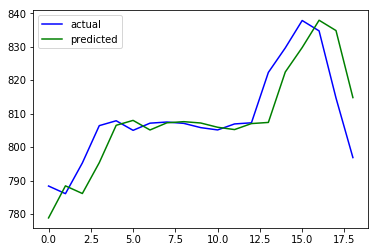

In [19]:
# unscale the data first
test_unscaled = scaler.inverse_transform(test_y)
pred_value_unscaled = scaler.inverse_transform(pred_value)

# plot the data points
plt.plot(test_unscaled[:],'b', label = 'actual')
plt.plot(pred_value_unscaled[:],'g', label = 'predicted')
plt.legend(loc=0)